In [1]:
import os

import matplotlib.pyplot as plt
import mne
import numpy as np
import pandas as pd
import pingouin as pg
import seaborn as sns
import xarray as xr
from plotting import plot_eeg_topomaps
from scipy.stats import zscore
from tqdm import tqdm
from utils import run_in_parallel

plt.style.use("papers")

DATA_FOLDER = "../../data/test_data_LEMON/"
RESULTS_FOLDER = "/Users/nikola/work-brain/eeg_microstate_and_latent_space/results/20220622_VARprocess_EC_50subjects_30.0s_segment_1200.0s_VARlength/"

# VAR orders

In [2]:
orders_raw = pd.read_csv(os.path.join(RESULTS_FOLDER, "VAR_orders_aic.csv"))
orders = []
for col in orders_raw.filter(like="sub"):
    orders.append(orders_raw[["order", col]].dropna(axis=0).set_index("order"))
orders = pd.concat(orders, axis=1)

mins = orders.idxmin()
display(mins)
display(mins.median(), mins.mean())

sub-010006_EC    12
sub-010027_EC    14
sub-010056_EC    11
sub-010044_EC    15
sub-010010_EC    15
sub-010042_EC    12
sub-010021_EC    13
sub-010049_EC     9
sub-010023_EC    14
sub-010035_EC    15
sub-010059_EC    12
sub-010069_EC    12
sub-010064_EC    10
sub-010068_EC    15
sub-010063_EC    17
sub-010157_EC    17
sub-010075_EC    15
sub-010094_EC    15
sub-010134_EC     8
sub-010141_EC    15
sub-010219_EC    15
sub-010162_EC    15
sub-010214_EC    13
sub-010168_EC    14
sub-010223_EC    12
sub-010231_EC    15
sub-010239_EC     6
sub-010227_EC    15
sub-010233_EC    17
sub-010241_EC    12
sub-010276_EC     3
sub-010244_EC    13
sub-010249_EC    14
sub-010243_EC    12
sub-010250_EC    16
sub-010271_EC    15
sub-010257_EC    13
sub-010269_EC    15
sub-010272_EC    13
sub-010283_EC     6
sub-010284_EC    13
sub-010288_EC    12
sub-010292_EC    13
sub-010297_EC    13
sub-010303_EC    15
sub-010299_EC    15
sub-010300_EC    15
sub-010316_EC    11
sub-010305_EC    17
sub-010319_EC    15


14.0

13.18

<AxesSubplot:xlabel='order', ylabel='AIC'>

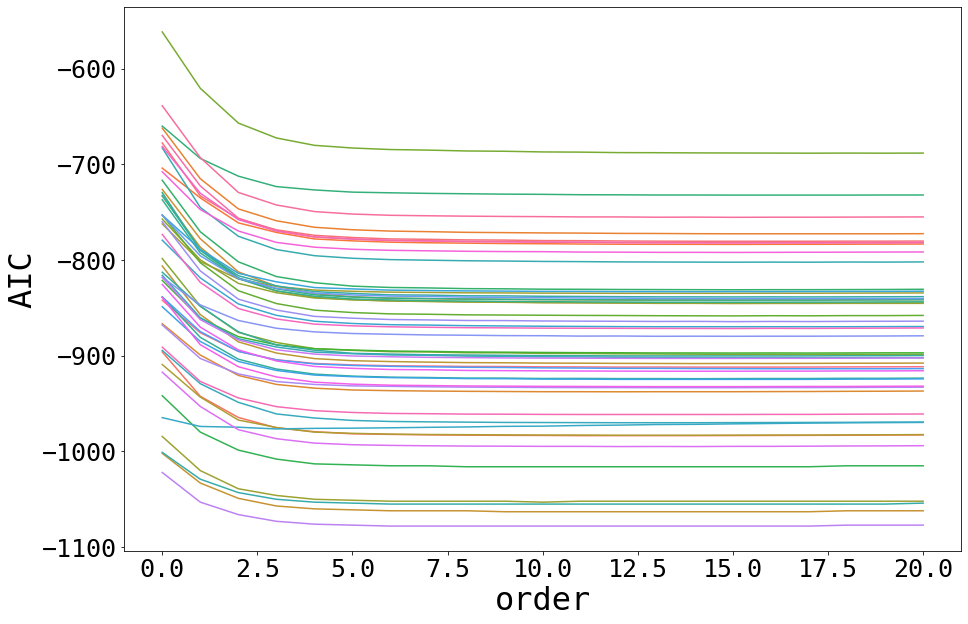

In [3]:
plt.figure(figsize=(15, 10))
sns.lineplot(
    data=orders.reset_index().melt(
        id_vars="order", value_name="AIC", var_name="subject"
    ),
    x="order",
    y="AIC",
    hue="subject",
    legend=False,
)

# Topomaps

In [4]:
topomaps = xr.open_dataarray(os.path.join(RESULTS_FOLDER, "topomaps.nc"))
topomaps = topomaps.set_index({"stack": ["subject_id", "type"]}).unstack()

/var/folders/8l/kg7qz2vn3jn9_bzjm1p_pgq40000gn/T/ipykernel_3860/2980343528.py:3: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  os.path.join(DATA_FOLDER, f"{subj_id}_EC.set"), preload=False
/var/folders/8l/kg7qz2vn3jn9_bzjm1p_pgq40000gn/T/ipykernel_3860/2980343528.py:3: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  os.path.join(DATA_FOLDER, f"{subj_id}_EC.set"), preload=False


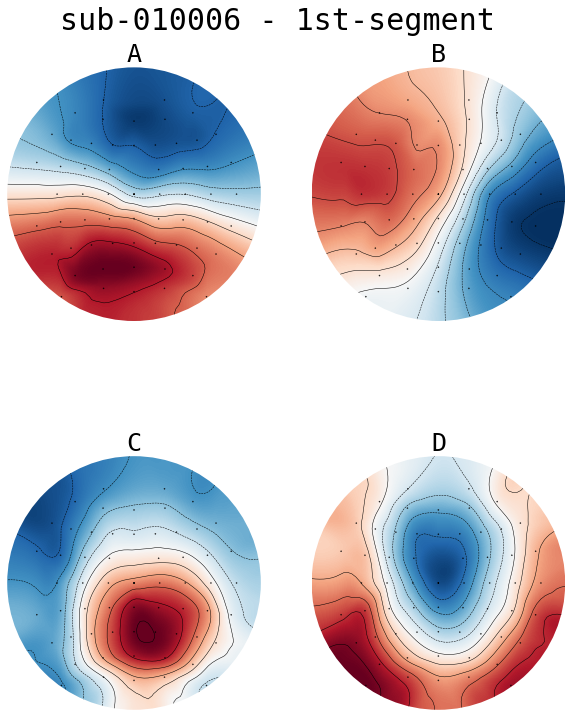

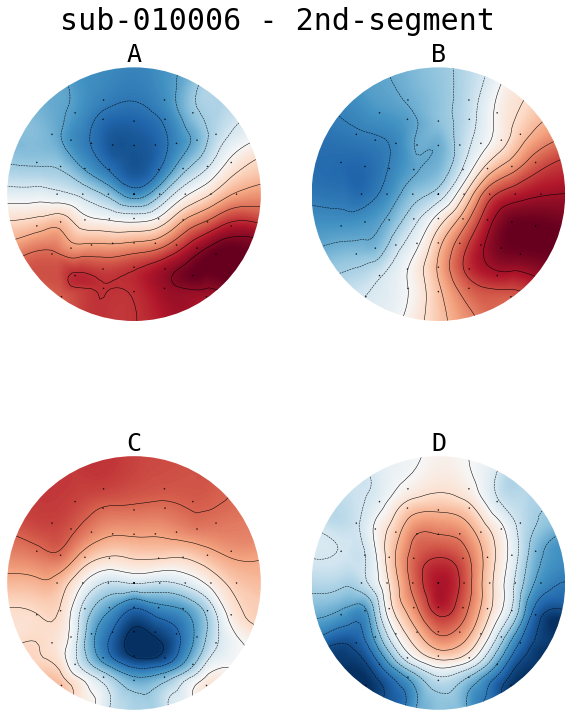

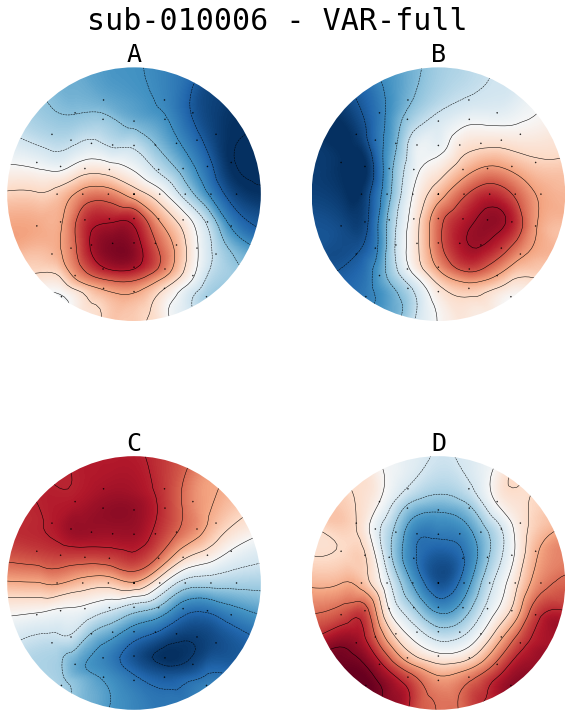

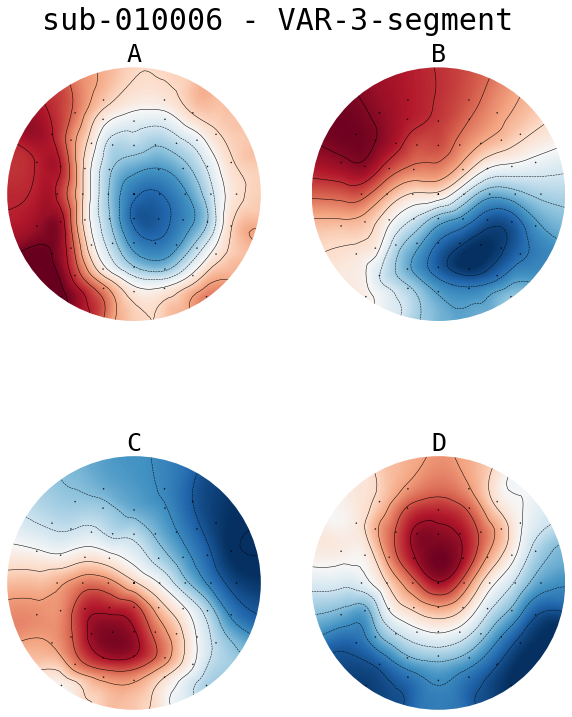

In [5]:
subj_id = "sub-010006"
subj_info = mne.io.read_raw_eeglab(
    os.path.join(DATA_FOLDER, f"{subj_id}_EC.set"), preload=False
)
PLOT_TYPES = ["1st-segment", "2nd-segment", "VAR-full", "VAR-3-segment"]

for plot_type in PLOT_TYPES:
    plot_eeg_topomaps(
        topomaps.sel({"subject_id": subj_id, "type": plot_type})
        .dropna("channels")
        .values,
        subj_info.info,
        title=subj_id + " - " + plot_type,
    )
    plt.show()

# Topomaps accordance

In [6]:
all_corrs = []
TYPES = list(topomaps["type"].values)
for typ1 in TYPES:
    for typ2 in TYPES:
        all_corrs.append(
            xr.corr(
                topomaps.sel({"type": typ1}),
                topomaps.sel({"type": typ2}),
                dim="channels",
            )
            .assign_coords({"type1": typ1, "type2": typ2})
            .expand_dims(["type1", "type2"])
        )

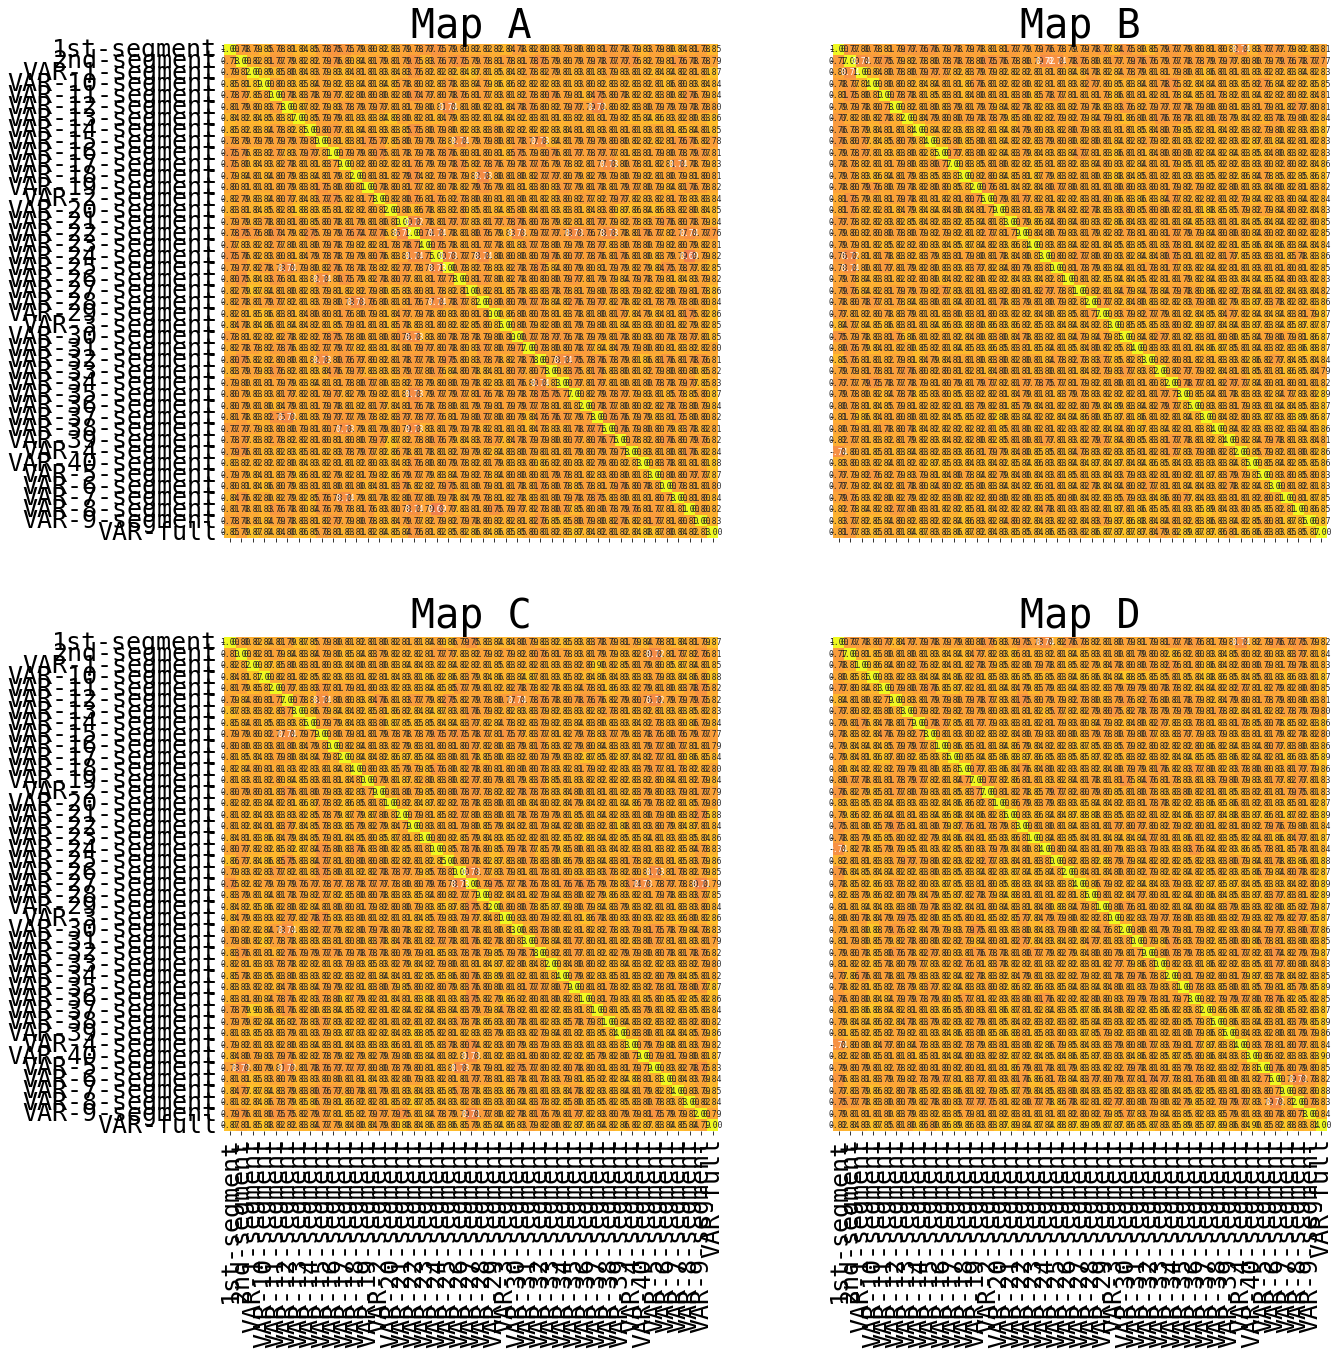

In [7]:
corrs = np.abs(xr.combine_by_coords(all_corrs))
corrs

fig, axs = plt.subplots(
    nrows=2, ncols=2, squeeze=True, figsize=(20, 20), sharey=True, sharex=True
)
axs = axs.flatten()
for i, lamap in enumerate(corrs["latent map"]):
    sns.heatmap(
        corrs.mean(dim="subject_id").sel({"latent map": lamap}),
        square=True,
        ax=axs[i],
        cbar=False,
        cmap="plasma",
        annot_kws={"size": 8},
        annot=True,
        vmin=0,
        vmax=1,
        fmt=".2f",
    )
    axs[i].set_xticks(np.arange(len(TYPES)) + 0.5, TYPES, rotation=90)
    axs[i].set_yticks(np.arange(len(TYPES)) + 0.5, TYPES, rotation=0)
    axs[i].set_title(f"Map {lamap.values}")

In [8]:
TYPES = ["1st-segment", "2nd-segment", "VAR-full"]
SUBJECTS = np.unique(topomaps.coords["subject_id"].values)


def _compute_corr(args):
    topomaps, typ1, typ2, subj1, subj2 = args
    return (
        xr.corr(
            topomaps.sel({"type": typ1, "subject_id": subj1}),
            topomaps.sel({"type": typ2, "subject_id": subj2}),
            dim="channels",
        )
        .assign_coords({"type1": typ1, "type2": typ2, "subj1": subj1, "subj2": subj2})
        .expand_dims(["type1", "type2", "subj1", "subj2"])
    )


all_corrs2 = run_in_parallel(
    _compute_corr,
    [
        (topomaps, typ1, typ2, subj1, subj2)
        for typ1 in TYPES
        for typ2 in TYPES
        for subj1 in SUBJECTS
        for subj2 in SUBJECTS
    ],
)

combined = np.abs(xr.combine_by_coords(all_corrs2))

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 22500/22500 [02:09<00:00, 174.32it/s]


Text(244.17015810276683, 0.5, 'full VAR $\\to$ 2nd seg.')

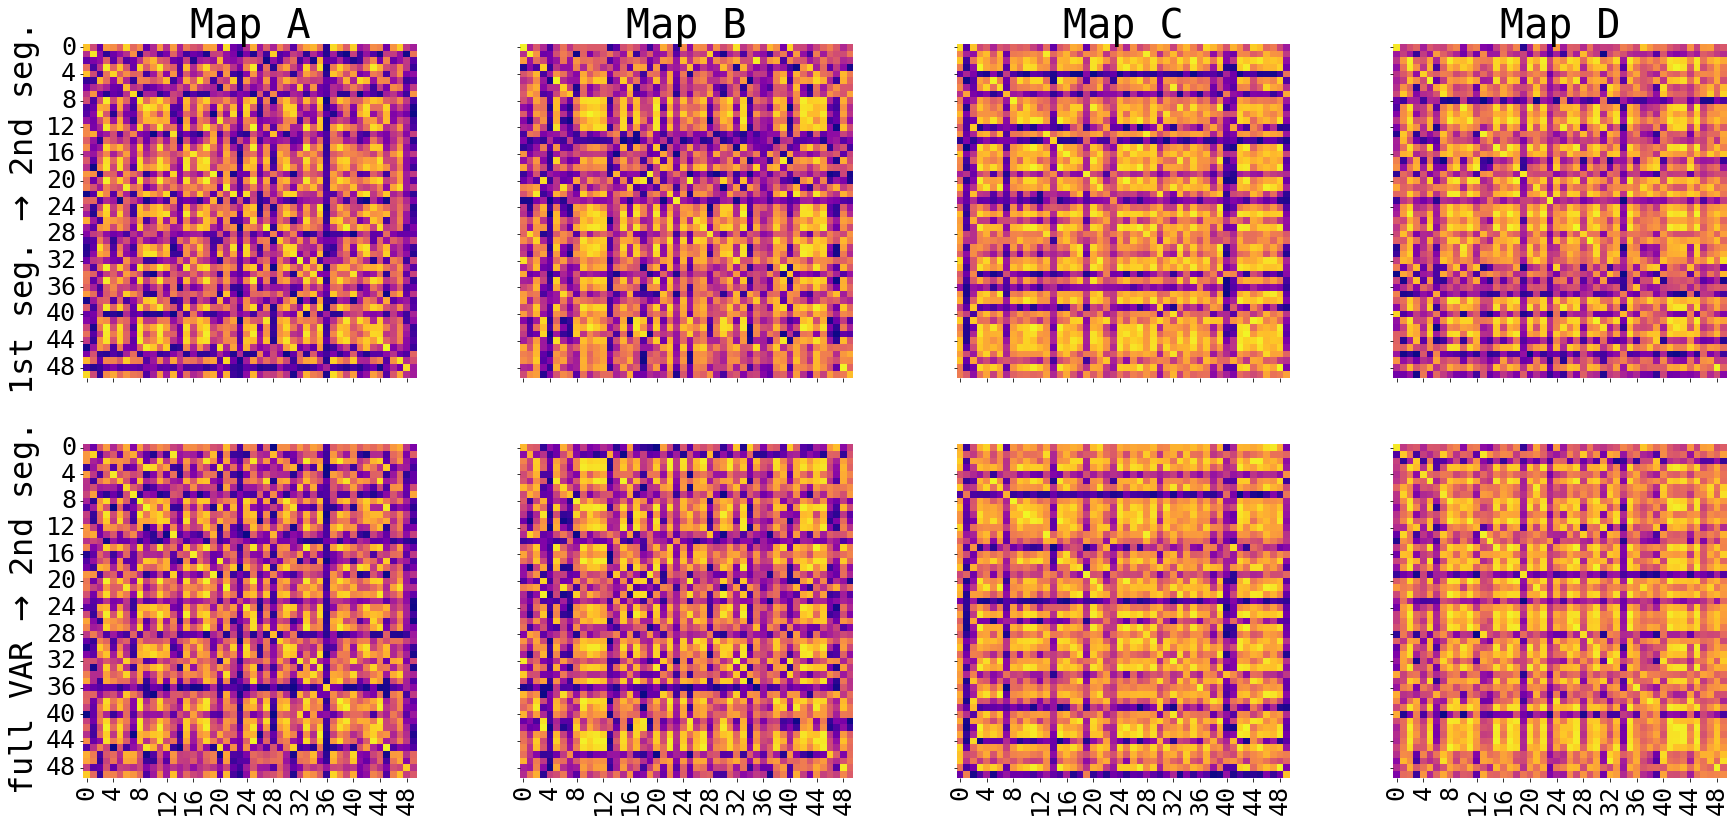

In [9]:
fig, axs = plt.subplots(
    nrows=2, ncols=4, squeeze=True, figsize=(30, 13.5), sharey=True, sharex=True
)

for i, lamap in enumerate(combined["latent map"]):
    for j, howto in enumerate(["1st-segment", "VAR-full"]):
        sns.heatmap(
            combined.sel({"type1": howto, "type2": "2nd-segment", "latent map": lamap}),
            square=True,
            ax=axs[j, i],
            cbar=False,
            cmap="plasma",
            vmin=0,
            vmax=1,
        )
    axs[0, i].set_title(f"Map {lamap.values}")
axs[0, 0].set_ylabel(r"1st seg. $\to$ 2nd seg.")
axs[1, 0].set_ylabel(r"full VAR $\to$ 2nd seg.")

Text(244.17015810276683, 0.5, 'full VAR $\\to$ 2nd seg.')

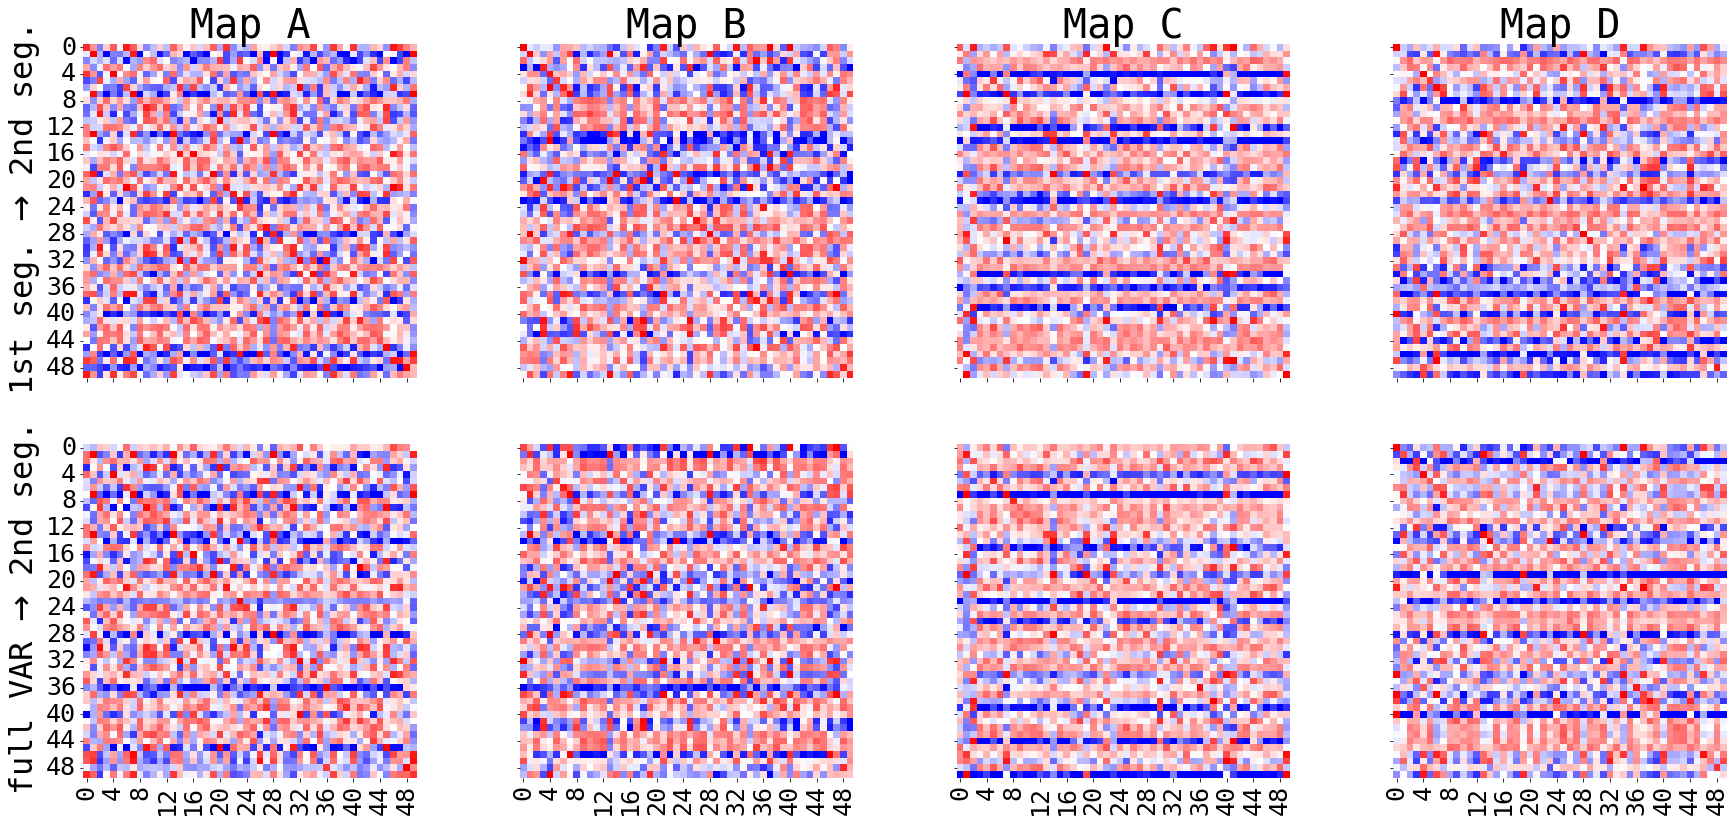

In [10]:
fig, axs = plt.subplots(
    nrows=2, ncols=4, squeeze=True, figsize=(30, 13.5), sharey=True, sharex=True
)
for i, lamap in enumerate(combined["latent map"]):
    for j, howto in enumerate(["1st-segment", "VAR-full"]):
        sns.heatmap(
            zscore(
                combined.sel(
                    {"type1": howto, "type2": "2nd-segment", "latent map": lamap}
                ).values,
                axis=0,
            ),
            square=True,
            ax=axs[j, i],
            cbar=False,
            cmap="bwr",
            vmin=-2.0,
            vmax=2.0,
        )
    axs[0, i].set_title(f"Map {lamap.values}")
axs[0, 0].set_ylabel(r"1st seg. $\to$ 2nd seg.")
axs[1, 0].set_ylabel(r"full VAR $\to$ 2nd seg.")

In [11]:
correct_classif = pd.DataFrame(
    columns=list(combined["latent map"].values), index=["1st-segment", "VAR-full"]
)

for lamap in combined["latent map"]:
    for howto in ["1st-segment", "VAR-full"]:
        correct_classif.loc[howto, str(lamap.values)] = (
            combined.sel(
                {"latent map": lamap, "type1": howto, "type2": "2nd-segment"}
            ).values.argmax(axis=0)
            == np.arange(len(SUBJECTS))
        ).sum()

display(correct_classif)

correct_classif_zs = pd.DataFrame(
    columns=list(combined["latent map"].values), index=["1st-segment", "VAR-full"]
)

for lamap in combined["latent map"]:
    for howto in ["1st-segment", "VAR-full"]:
        correct_classif_zs.loc[howto, str(lamap.values)] = (
            zscore(
                combined.sel(
                    {"latent map": lamap, "type1": howto, "type2": "2nd-segment"}
                ).values,
                axis=0,
            ).argmax(axis=0)
            == np.arange(len(SUBJECTS))
        ).sum()

display(correct_classif_zs)

,A,B,C,D
1st-segment,19,14,12,17
VAR-full,19,9,16,18


,A,B,C,D
1st-segment,19,14,12,17
VAR-full,19,9,16,18


# Static and dynamic stats

In [12]:
static_stats = pd.read_csv(
    os.path.join(RESULTS_FOLDER, "static_stats.csv"), index_col=0
)
static_stats[["subject_id", "type"]] = (
    static_stats["subject_id"].str.split("_", expand=True).drop([1], axis=1)
)
static_stats = static_stats.drop(
    ["filter", "decomposition_type", "use_gfp", "no_states"], axis=1
).sort_values(["subject_id", "type", "latent map"])
# make mean / std from VAR segments
var_means = (
    static_stats.loc[static_stats["type"].str.match("VAR-\d*-segment")]
    .groupby(["subject_id", "latent map"])
    .mean()
    .reset_index()
)
var_means["type"] = "VAR-segments-mean"

static_stats_final = pd.concat(
    [static_stats.loc[~static_stats["type"].str.match("VAR-\d*-segment")], var_means],
    axis=0,
)
static_stats_final = static_stats_final.set_index(["subject_id", "type", "latent map"])
static_stats_final

var_GFP  var_total  template_corr  \
subject_id type              latent map                                       
sub-010006 1st-segment       A           0.709617   0.675651       0.837460   
                             B           0.709617   0.675651       0.846780   
                             C           0.709617   0.675651       0.823881   
                             D           0.709617   0.675651       0.869961   
           2nd-segment       A           0.761654   0.731332       0.749023   
...                                           ...        ...            ...   
sub-010316 VAR-segments-mean D           0.820112   0.752816       0.920794   
sub-010319 VAR-segments-mean A           0.762812   0.705783       0.764050   
                             B           0.762812   0.705783       0.820567   
                             C           0.762812   0.705783       0.854210   
                             D           0.762812   0.705783       0.822728   

                                         coverage  occurrence   lifespan  \
subject_id type              latent map                                    
sub-010006 1st-segment       A           0.256899   14.898014  17.234899   
                             B           0.275163   14.798027  18.627540   
                             C           0.217038   13.931476  15.578947   
                             D           0.250900   15.331289  16.365217   
           2nd-segment       A           0.265831   14.398080  18.385151   
...                                           ...         ...        ...   
sub-010316 VAR-segments-mean D           0.254240   12.878328  19.776394   
sub-010319 VAR-segments-mean A           0.240715   13.439916  17.933238   
                             B           0.249071   13.583236  18.289153   
                             C           0.251874   13.829868  18.198372   
                             D           0.258340   14.163160  18.240885   

                                         transition->A  transition->B  \
subject_id type              latent map                                 
sub-010006 1st-segment       A                0.767913       0.084631   
                             B                0.073643       0.784884   
                             C                0.091523       0.082924   
                             D                0.078108       0.077046   
           2nd-segment       A                0.783350       0.060181   
...                                                ...            ...   
sub-010316 VAR-segments-mean D                0.062925       0.083462   
sub-010319 VAR-segments-mean A                0.776104       0.074700   
                             B                0.067228       0.780514   
                             C                0.074807       0.069769   
                             D                0.071024       0.074209   

                                         transition->C  transition->D  
subject_id type              latent map                                
sub-010006 1st-segment       A                0.063344       0.084112  
                             B                0.062016       0.079457  
                             C                0.743243       0.082310  
                             D                0.089267       0.755579  
           2nd-segment       A                0.049649       0.106820  
...                                                ...            ...  
sub-010316 VAR-segments-mean D                0.057125       0.796488  
sub-010319 VAR-segments-mean A                0.076100       0.073096  
                             B                0.071386       0.080872  
                             C                0.779410       0.076014  
                             D                0.075159       0.779609  

[800 rows x 10 columns]

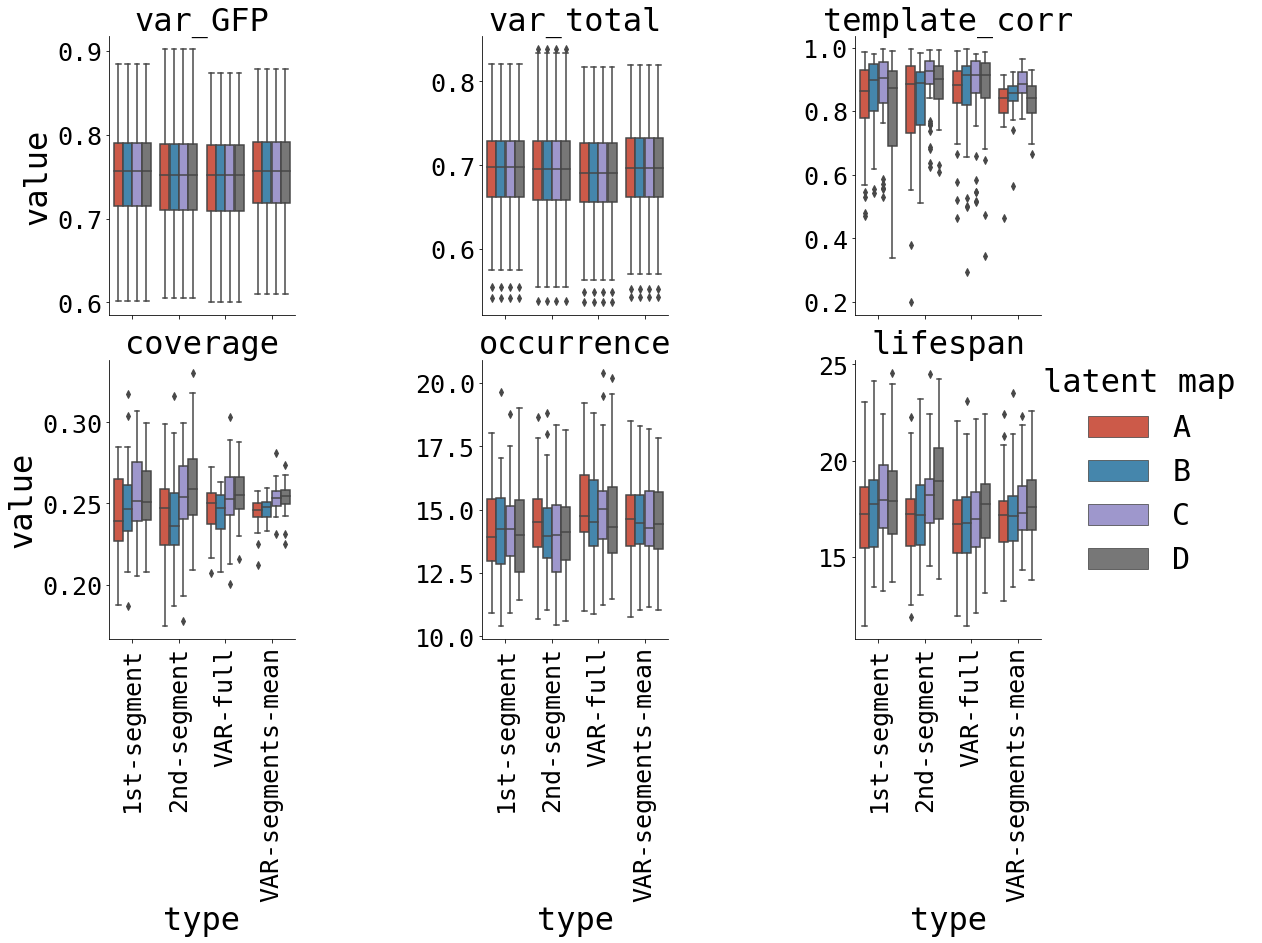

In [13]:
melt = static_stats_final.reset_index().melt(
    id_vars=["latent map", "type", "subject_id"],
    value_vars=[
        "var_GFP",
        "var_total",
        "template_corr",
        "coverage",
        "occurrence",
        "lifespan",
    ],
)
g = sns.catplot(
    data=melt,
    col="variable",
    col_wrap=3,
    hue="latent map",
    x="type",
    y="value",
    kind="box",
    sharey=False,
)
g.set_titles(col_template="{col_name}")
g.set_xticklabels(rotation=90)

In [14]:
STATS_COLS = [
    "var_GFP",
    "var_total",
    "template_corr",
    "coverage",
    "occurrence",
    "lifespan",
    "transition->A",
    "transition->B",
    "transition->C",
    "transition->D",
]

real_data_diff = (
    static_stats[static_stats["type"] == "2nd-segment"]
    .sort_values(["subject_id", "latent map"])
    .set_index(["subject_id", "latent map"])[STATS_COLS]
    - static_stats[static_stats["type"] == "1st-segment"]
    .sort_values(["subject_id", "latent map"])
    .set_index(["subject_id", "latent map"])[STATS_COLS]
)

var_full_diff = (
    static_stats[static_stats["type"] == "2nd-segment"]
    .sort_values(["subject_id", "latent map"])
    .set_index(["subject_id", "latent map"])[STATS_COLS]
    - static_stats[static_stats["type"] == "VAR-full"]
    .sort_values(["subject_id", "latent map"])
    .set_index(["subject_id", "latent map"])[STATS_COLS]
)

all_segments = sorted(
    static_stats["type"][static_stats["type"].str.match(r"VAR-\d*-segment")].unique()
)
all_segments_diffs = []
for segment in all_segments:
    df_temp = (
        static_stats[static_stats["type"] == "2nd-segment"]
        .sort_values(["subject_id", "latent map"])
        .set_index(["subject_id", "latent map"])[STATS_COLS]
        - static_stats[static_stats["type"] == segment]
        .sort_values(["subject_id", "latent map"])
        .set_index(["subject_id", "latent map"])[STATS_COLS]
    )
    df_temp["segment"] = segment
    all_segments_diffs.append(df_temp)
all_segments_diffs = pd.concat(all_segments_diffs)
var_segments_diff_mean = (
    all_segments_diffs.reset_index().groupby(["subject_id", "latent map"]).mean()
)

real_data_diff["diffs"] = "real_data"
var_full_diff["diffs"] = "VAR-full"
var_segments_diff_mean["diffs"] = "VAR-segments"
static_diffs = pd.concat([real_data_diff, var_full_diff, var_segments_diff_mean]).reset_index()

In [15]:
DVS = ["var_GFP", "var_total", "template_corr", "coverage", "occurrence", "lifespan"]

for dv in DVS:
    print(f"== {dv} ==")
    display(pg.rm_anova(data=static_diffs, dv=dv, within="diffs", subject="subject_id"))
    display(pg.pairwise_ttests(data=static_diffs, dv=dv, within="diffs", subject="subject_id", padjust="fdr_by"))

== var_GFP ==


/Users/nikola/.virtualenvs/eeg_latent/lib/python3.7/site-packages/pingouin/distribution.py:977: RuntimeWarning: divide by zero encountered in double_scalars
  W = np.product(eig) / (eig.sum() / d) ** d


,Source,ddof1,ddof2,F,p-unc,ng2,eps
0,diffs,2,98,69.99468,1.314493e-19,0.016648,0.728465


/Users/nikola/.virtualenvs/eeg_latent/lib/python3.7/site-packages/pingouin/pairwise.py:27: UserWarning: pairwise_ttests is deprecated, use pairwise_tests instead.
  warnings.warn("pairwise_ttests is deprecated, use pairwise_tests instead.", UserWarning)


,Contrast,A,B,Paired,Parametric,T,dof,alternative,p-unc,p-corr,p-adjust,BF10,hedges
0,diffs,VAR-full,VAR-segments,True,True,17.890744,49.0,two-sided,3.977879e-23,2.187833e-22,fdr_by,9.922e+19,0.297805
1,diffs,VAR-full,real_data,True,True,7.944821,49.0,two-sided,2.320334e-10,6.380918e-10,fdr_by,4.516e+07,0.233273
2,diffs,VAR-segments,real_data,True,True,-2.004454,49.0,two-sided,5.056406e-02,9.270078e-02,fdr_by,0.968,-0.062039


== var_total ==


/Users/nikola/.virtualenvs/eeg_latent/lib/python3.7/site-packages/pingouin/distribution.py:977: RuntimeWarning: divide by zero encountered in double_scalars
  W = np.product(eig) / (eig.sum() / d) ** d


,Source,ddof1,ddof2,F,p-unc,ng2,eps
0,diffs,2,98,112.684167,3.934602e-26,0.011089,0.652382


/Users/nikola/.virtualenvs/eeg_latent/lib/python3.7/site-packages/pingouin/pairwise.py:27: UserWarning: pairwise_ttests is deprecated, use pairwise_tests instead.
  warnings.warn("pairwise_ttests is deprecated, use pairwise_tests instead.", UserWarning)


,Contrast,A,B,Paired,Parametric,T,dof,alternative,p-unc,p-corr,p-adjust,BF10,hedges
0,diffs,VAR-full,VAR-segments,True,True,24.707137,49.0,two-sided,2.574414e-29,1.415928e-28,fdr_by,1.077e+26,0.219941
1,diffs,VAR-full,real_data,True,True,11.420242,49.0,two-sided,2.044547e-15,5.622504e-15,fdr_by,3.259e+12,0.221563
2,diffs,VAR-segments,real_data,True,True,0.195752,49.0,two-sided,8.456138e-01,1.000000e+00,fdr_by,0.157,0.003940


== template_corr ==


,Source,ddof1,ddof2,F,p-unc,ng2,eps
0,diffs,2,98,6.219396,0.002865,0.030234,0.742074


/Users/nikola/.virtualenvs/eeg_latent/lib/python3.7/site-packages/pingouin/pairwise.py:27: UserWarning: pairwise_ttests is deprecated, use pairwise_tests instead.
  warnings.warn("pairwise_ttests is deprecated, use pairwise_tests instead.", UserWarning)


,Contrast,A,B,Paired,Parametric,T,dof,alternative,p-unc,p-corr,p-adjust,BF10,hedges
0,diffs,VAR-full,VAR-segments,True,True,-2.699827,49.0,two-sided,0.009496,0.026113,fdr_by,3.929,-0.264367
1,diffs,VAR-full,real_data,True,True,-2.796406,49.0,two-sided,0.007362,0.026113,fdr_by,4.894,-0.391743
2,diffs,VAR-segments,real_data,True,True,-1.563783,49.0,two-sided,0.124305,0.227892,fdr_by,0.479,-0.177505


== coverage ==


/Users/nikola/.virtualenvs/eeg_latent/lib/python3.7/site-packages/pingouin/distribution.py:977: RuntimeWarning: divide by zero encountered in double_scalars
  W = np.product(eig) / (eig.sum() / d) ** d


,Source,ddof1,ddof2,F,p-unc,ng2,eps
0,diffs,2,98,0.413013,0.6628,0.00218,0.976791


/Users/nikola/.virtualenvs/eeg_latent/lib/python3.7/site-packages/pingouin/pairwise.py:27: UserWarning: pairwise_ttests is deprecated, use pairwise_tests instead.
  warnings.warn("pairwise_ttests is deprecated, use pairwise_tests instead.", UserWarning)


,Contrast,A,B,Paired,Parametric,T,dof,alternative,p-unc,p-corr,p-adjust,BF10,hedges
0,diffs,VAR-full,VAR-segments,True,True,-0.817676,49.0,two-sided,0.417501,1.0,fdr_by,0.211,-0.100054
1,diffs,VAR-full,real_data,True,True,-0.733752,49.0,two-sided,0.466597,1.0,fdr_by,0.199,-0.090820
2,diffs,VAR-segments,real_data,True,True,-0.002467,49.0,two-sided,0.998042,1.0,fdr_by,0.154,-0.000309


== occurrence ==


,Source,ddof1,ddof2,F,p-unc,p-GG-corr,ng2,eps,sphericity,W-spher,p-spher
0,diffs,2,98,36.512401,1.413129e-12,2.562336e-10,0.091889,0.780287,False,0.718421,0.000357


/Users/nikola/.virtualenvs/eeg_latent/lib/python3.7/site-packages/pingouin/pairwise.py:27: UserWarning: pairwise_ttests is deprecated, use pairwise_tests instead.
  warnings.warn("pairwise_ttests is deprecated, use pairwise_tests instead.", UserWarning)


,Contrast,A,B,Paired,Parametric,T,dof,alternative,p-unc,p-corr,p-adjust,BF10,hedges
0,diffs,VAR-full,VAR-segments,True,True,-5.256898,49.0,two-sided,3.187443e-06,8.765469e-06,fdr_by,5544.34,-0.384943
1,diffs,VAR-full,real_data,True,True,-6.923002,49.0,two-sided,8.730428e-09,4.801735e-08,fdr_by,1.431e+06,-0.722747
2,diffs,VAR-segments,real_data,True,True,-4.728599,49.0,two-sided,1.948899e-05,3.572982e-05,fdr_by,1032.275,-0.405803


== lifespan ==


,Source,ddof1,ddof2,F,p-unc,p-GG-corr,ng2,eps,sphericity,W-spher,p-spher
0,diffs,2,98,41.72462,7.781713e-14,1.562416e-10,0.101507,0.713149,False,0.597768,0.000004


/Users/nikola/.virtualenvs/eeg_latent/lib/python3.7/site-packages/pingouin/pairwise.py:27: UserWarning: pairwise_ttests is deprecated, use pairwise_tests instead.
  warnings.warn("pairwise_ttests is deprecated, use pairwise_tests instead.", UserWarning)


,Contrast,A,B,Paired,Parametric,T,dof,alternative,p-unc,p-corr,p-adjust,BF10,hedges
0,diffs,VAR-full,VAR-segments,True,True,5.949696,49.0,two-sided,2.797377e-07,7.692787e-07,fdr_by,5.411e+04,0.362234
1,diffs,VAR-full,real_data,True,True,7.329799,49.0,two-sided,2.049059e-09,1.126982e-08,fdr_by,5.667e+06,0.767424
2,diffs,VAR-segments,real_data,True,True,5.112935,49.0,two-sided,5.245747e-06,9.617204e-06,fdr_by,3486.334,0.466184


In [16]:
dynamic_stats = pd.read_csv(
    os.path.join(RESULTS_FOLDER, "dynamic_stats.csv"), index_col=0
)
dynamic_stats[["subject_id", "type"]] = (
    dynamic_stats["subject_id"].str.split("_", expand=True).drop([1], axis=1)
)
dynamic_stats = dynamic_stats.sort_values(["subject_id", "type"])
# make mean / std from VAR segments
var_means = (
    dynamic_stats.loc[dynamic_stats["type"].str.match("VAR-\d*-segment")]
    .groupby(["subject_id"])
    .mean()
    .reset_index()
)
var_means["type"] = "VAR-segments-mean"

dynamic_stats_final = pd.concat(
    [dynamic_stats.loc[~dynamic_stats["type"].str.match("VAR-\d*-segment")], var_means],
    axis=0,
)
dynamic_stats_final = dynamic_stats_final.set_index(["subject_id", "type"])
dynamic_stats_final

mixing time   entropy  max entropy  \
subject_id type                                                    
sub-010006 1st-segment           3.352397  1.994810          2.0   
           2nd-segment           3.362750  1.998596          2.0   
           VAR-full              3.148651  1.999947          2.0   
sub-010010 1st-segment           3.480506  1.993318          2.0   
           2nd-segment           3.579928  1.986213          2.0   
...                                   ...       ...          ...   
sub-010300 VAR-segments-mean     3.595907  1.987778          2.0   
sub-010303 VAR-segments-mean     3.652205  1.992215          2.0   
sub-010305 VAR-segments-mean     3.595151  1.991637          2.0   
sub-010316 VAR-segments-mean     3.888286  1.992410          2.0   
sub-010319 VAR-segments-mean     3.600590  1.991046          2.0   

                              entropy_rate  MC entropy rate  AIF 1st peak  
subject_id type                                                            
sub-010006 1st-segment            1.111102         1.159522          44.0  
           2nd-segment            1.076738         1.124440          56.0  
           VAR-full               1.155229         1.182502          44.0  
sub-010010 1st-segment            1.045879         1.094164          52.0  
           2nd-segment            1.032943         1.078852          56.0  
...                                    ...              ...           ...  
sub-010300 VAR-segments-mean      1.049261         1.099736          52.2  
sub-010303 VAR-segments-mean      1.066836         1.111929          46.8  
sub-010305 VAR-segments-mean      1.033676         1.082471          52.2  
sub-010316 VAR-segments-mean      1.019325         1.067649          51.2  
sub-010319 VAR-segments-mean      1.053545         1.103606          51.2  

[200 rows x 6 columns]

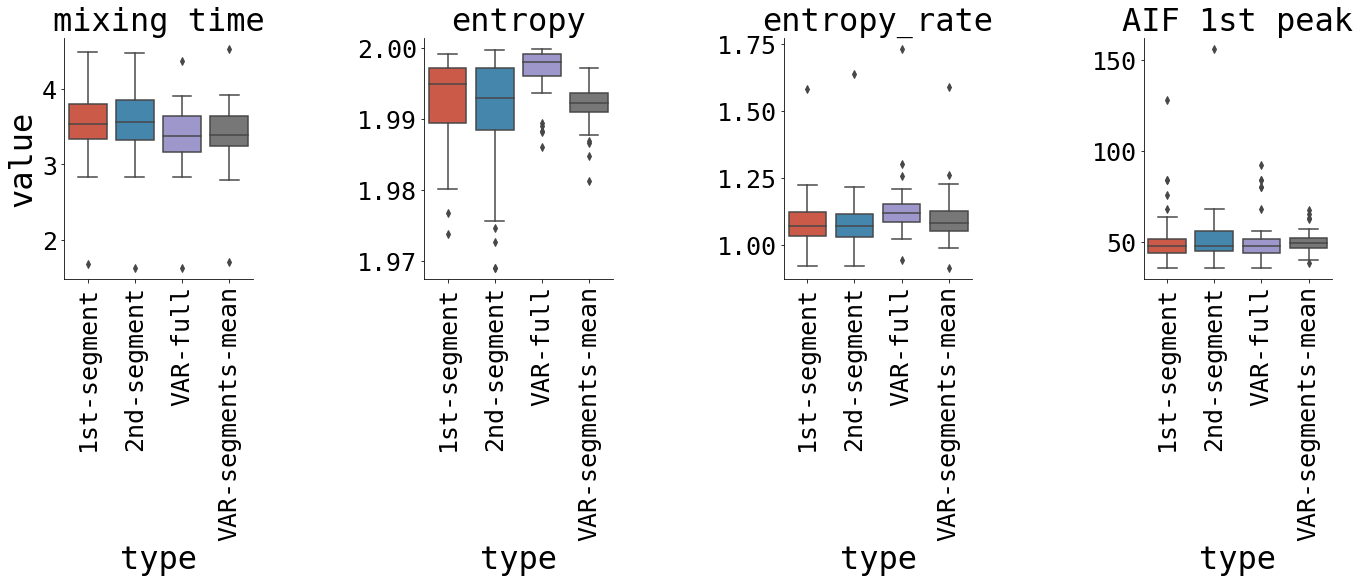

In [17]:
g = sns.catplot(
    data=dynamic_stats_final.reset_index().melt(
        id_vars=["subject_id", "type"],
        value_vars=["mixing time", "entropy", "entropy_rate", "AIF 1st peak"],
    ),
    col="variable",
    col_wrap=4,
    x="type",
    y="value",
    kind="box",
    sharey=False,
)
g.set_titles(col_template="{col_name}")
g.set_xticklabels(rotation=90)

In [18]:
dynamic_stats

,subject_id,mixing time,entropy,max entropy,entropy_rate,MC entropy rate,AIF 1st peak,type
0,sub-010006,3.352397,1.994810,2.0,1.111102,1.159522,44.0,1st-segment
0,sub-010006,3.362750,1.998596,2.0,1.076738,1.124440,56.0,2nd-segment
0,sub-010006,3.199252,1.995916,2.0,1.133546,1.179895,60.0,VAR-1-segment
0,sub-010006,3.239370,1.997957,2.0,1.113314,1.159316,40.0,VAR-10-segment
0,sub-010006,3.239603,1.990064,2.0,1.111742,1.156283,44.0,VAR-11-segment
...,...,...,...,...,...,...,...,...
0,sub-010319,3.673656,1.994242,2.0,1.069996,1.120129,52.0,VAR-6-segment
0,sub-010319,3.670696,1.997219,2.0,1.050700,1.103095,52.0,VAR-7-segment
0,sub-010319,3.458858,1.971545,2.0,1.039901,1.095025,52.0,VAR-8-segment
0,sub-010319,3.485965,1.996497,2.0,1.056632,1.105624,52.0,VAR-9-segment


In [19]:
STATS_COLS = [
    "mixing time",
    "entropy",
    "entropy_rate",
    "AIF 1st peak",
]

real_data_diff = (
    dynamic_stats[dynamic_stats["type"] == "2nd-segment"]
    .sort_values(["subject_id"])
    .set_index(["subject_id"])[STATS_COLS]
    - dynamic_stats[dynamic_stats["type"] == "1st-segment"]
    .sort_values(["subject_id"])
    .set_index(["subject_id"])[STATS_COLS]
)

var_full_diff = (
    dynamic_stats[dynamic_stats["type"] == "2nd-segment"]
    .sort_values(["subject_id"])
    .set_index(["subject_id"])[STATS_COLS]
    - dynamic_stats[dynamic_stats["type"] == "VAR-full"]
    .sort_values(["subject_id"])
    .set_index(["subject_id"])[STATS_COLS]
)

all_segments = sorted(
    dynamic_stats["type"][dynamic_stats["type"].str.match(r"VAR-\d*-segment")].unique()
)
all_segments_diffs = []
for segment in all_segments:
    df_temp = (
        dynamic_stats[dynamic_stats["type"] == "2nd-segment"]
        .sort_values(["subject_id"])
        .set_index(["subject_id"])[STATS_COLS]
        - dynamic_stats[dynamic_stats["type"] == segment]
        .sort_values(["subject_id"])
        .set_index(["subject_id"])[STATS_COLS]
    )
    df_temp["segment"] = segment
    all_segments_diffs.append(df_temp)
all_segments_diffs = pd.concat(all_segments_diffs)
var_segments_diff_mean = (
    all_segments_diffs.reset_index().groupby(["subject_id"]).mean()
)

real_data_diff["diffs"] = "real_data"
var_full_diff["diffs"] = "VAR-full"
var_segments_diff_mean["diffs"] = "VAR-segments"
dynamic_diffs = pd.concat([real_data_diff, var_full_diff, var_segments_diff_mean]).reset_index()

In [20]:
dynamic_diffs

,subject_id,mixing time,entropy,entropy_rate,AIF 1st peak,diffs
0,sub-010006,0.010353,0.003785,-0.034364,12.0,real_data
1,sub-010010,0.099421,-0.007105,-0.012937,4.0,real_data
2,sub-010021,0.261659,-0.004436,-0.070081,12.0,real_data
3,sub-010023,-0.402332,-0.003371,0.039251,-40.0,real_data
4,sub-010027,-0.115707,-0.001971,-0.026590,4.0,real_data
...,...,...,...,...,...,...
145,sub-010300,-0.049829,0.004999,0.003443,-0.2,VAR-segments
146,sub-010303,-0.061775,0.001031,0.007249,1.2,VAR-segments
147,sub-010305,0.470515,-0.002158,-0.045057,3.8,VAR-segments
148,sub-010316,0.230711,-0.016883,-0.036620,0.8,VAR-segments


In [21]:
DVS = ["mixing time", "entropy", "entropy_rate", "AIF 1st peak"]

for dv in DVS:
    print(f"== {dv} ==")
    display(pg.rm_anova(data=dynamic_diffs, dv=dv, within="diffs", subject="subject_id"))
    display(pg.pairwise_ttests(data=dynamic_diffs, dv=dv, within="diffs", subject="subject_id", padjust="fdr_by"))

== mixing time ==


,Source,ddof1,ddof2,F,p-unc,p-GG-corr,ng2,eps,sphericity,W-spher,p-spher
0,diffs,2,98,28.191345,2.131798e-10,3.977768e-07,0.106566,0.600144,False,0.333733,3.643931e-12


/Users/nikola/.virtualenvs/eeg_latent/lib/python3.7/site-packages/pingouin/pairwise.py:27: UserWarning: pairwise_ttests is deprecated, use pairwise_tests instead.
  warnings.warn("pairwise_ttests is deprecated, use pairwise_tests instead.", UserWarning)


,Contrast,A,B,Paired,Parametric,T,dof,alternative,p-unc,p-corr,p-adjust,BF10,hedges
0,diffs,VAR-full,VAR-segments,True,True,3.983038,49.0,two-sided,2.253010e-04,0.000413,fdr_by,109.335,0.208599
1,diffs,VAR-full,real_data,True,True,5.728053,49.0,two-sided,6.124439e-07,0.000003,fdr_by,2.593e+04,0.771059
2,diffs,VAR-segments,real_data,True,True,4.925482,49.0,two-sided,9.984202e-06,0.000027,fdr_by,1917.557,0.609719


== entropy ==


/Users/nikola/.virtualenvs/eeg_latent/lib/python3.7/site-packages/pingouin/distribution.py:977: RuntimeWarning: divide by zero encountered in double_scalars
  W = np.product(eig) / (eig.sum() / d) ** d


,Source,ddof1,ddof2,F,p-unc,ng2,eps
0,diffs,2,98,21.528892,1.776732e-08,0.068702,0.660443


/Users/nikola/.virtualenvs/eeg_latent/lib/python3.7/site-packages/pingouin/pairwise.py:27: UserWarning: pairwise_ttests is deprecated, use pairwise_tests instead.
  warnings.warn("pairwise_ttests is deprecated, use pairwise_tests instead.", UserWarning)


,Contrast,A,B,Paired,Parametric,T,dof,alternative,p-unc,p-corr,p-adjust,BF10,hedges
0,diffs,VAR-full,VAR-segments,True,True,-10.918126,49.0,two-sided,1.006197e-14,5.534086e-14,fdr_by,6.996e+11,-0.627081
1,diffs,VAR-full,real_data,True,True,-4.101580,49.0,two-sided,1.542926e-04,4.243047e-04,fdr_by,154.338,-0.491974
2,diffs,VAR-segments,real_data,True,True,0.995290,49.0,two-sided,3.244851e-01,5.948893e-01,fdr_by,0.245,0.106824


== entropy_rate ==


/Users/nikola/.virtualenvs/eeg_latent/lib/python3.7/site-packages/pingouin/distribution.py:977: RuntimeWarning: divide by zero encountered in double_scalars
  W = np.product(eig) / (eig.sum() / d) ** d


,Source,ddof1,ddof2,F,p-unc,ng2,eps
0,diffs,2,98,105.869531,3.245449e-25,0.289813,0.716593


/Users/nikola/.virtualenvs/eeg_latent/lib/python3.7/site-packages/pingouin/pairwise.py:27: UserWarning: pairwise_ttests is deprecated, use pairwise_tests instead.
  warnings.warn("pairwise_ttests is deprecated, use pairwise_tests instead.", UserWarning)


,Contrast,A,B,Paired,Parametric,T,dof,alternative,p-unc,p-corr,p-adjust,BF10,hedges
0,diffs,VAR-full,VAR-segments,True,True,-14.155684,49.0,two-sided,6.118143e-19,3.364979e-18,fdr_by,8.432e+15,-1.207267
1,diffs,VAR-full,real_data,True,True,-11.126648,49.0,two-sided,5.170918e-15,1.422003e-14,fdr_by,1.33e+12,-1.419321
2,diffs,VAR-segments,real_data,True,True,-4.027588,49.0,two-sided,1.955251e-04,3.584626e-04,fdr_by,124.383,-0.380487


== AIF 1st peak ==


,Source,ddof1,ddof2,F,p-unc,p-GG-corr,ng2,eps,sphericity,W-spher,p-spher
0,diffs,2,98,0.42514,0.654878,0.597626,0.002018,0.750821,False,0.668125,0.000063


/Users/nikola/.virtualenvs/eeg_latent/lib/python3.7/site-packages/pingouin/pairwise.py:27: UserWarning: pairwise_ttests is deprecated, use pairwise_tests instead.
  warnings.warn("pairwise_ttests is deprecated, use pairwise_tests instead.", UserWarning)


,Contrast,A,B,Paired,Parametric,T,dof,alternative,p-unc,p-corr,p-adjust,BF10,hedges
0,diffs,VAR-full,VAR-segments,True,True,-0.507386,49.0,two-sided,0.614160,1.0,fdr_by,0.174,-0.040968
1,diffs,VAR-full,real_data,True,True,0.445474,49.0,two-sided,0.657939,1.0,fdr_by,0.169,0.063862
2,diffs,VAR-segments,real_data,True,True,0.936091,49.0,two-sided,0.353817,1.0,fdr_by,0.233,0.114766
